In [702]:
import pandas as pd
import os
import random
import numpy as np
import pickle
import subprocess

import matplotlib.pyplot as plt
import seaborn as sns

In [703]:
dict_files = [i for i in os.listdir('results/') if 'run' in i]
all_params = {}
for i in dict_files:
    runid = i.replace('run_', '').replace('.txt', '').replace('self', '')
    if len(runid)>5: ## this are all the selfers 
        params = pd.read_csv(f'results/{i}',header=None)[0].values[0].split('_')
        all_params[runid] = params
len(all_params)

210

In [704]:
results = {}
for runid, params in all_params.items():
    k=2
    #print(runid)
    all_alt_allele_count = pd.read_csv(f'results/alleles_df/all_alt_allele_count_{runid}.csv').set_index('Unnamed: 0')
    
    pops_survived = len(all_alt_allele_count.columns)
    
    snps_wcline = pd.read_csv(f'results/snps_w_clines/snps_w_clines_{runid}.csv')

    if 15005 in snps_wcline['SNP'].values:
        causal_cline = snps_wcline[snps_wcline['SNP'] == 15005]['Color'].values[0]
    else:
        causal_cline = np.nan
    snps_wcline = snps_wcline['Color'].value_counts().reset_index().set_index('Color').T

    if 'blue' in snps_wcline.columns:
        no_cline = snps_wcline['blue'].values[0]
    else:
        no_cline = 0 
    if 'green' in snps_wcline.columns:
        pos_cline = snps_wcline['green'].values[0]
    else:
        pos_cline = 0 
    if 'red' in snps_wcline.columns:
        neg_cline = snps_wcline['red'].values[0]
    else:
        neg_cline = 0 
    
    p_values = pd.read_csv(f'lfmm/results/wo_calibration_pvalue_full_genome_{runid}_k{k}.csv').reset_index().drop( 'Unnamed: 0', axis=1)
    
    left_pos = pd.read_csv(f'lfmm/left_pos/left_pos_{runid}.csv')
    
    p_values = p_values.merge(left_pos, left_on = 'index', right_on = 'ignore', how = 'inner').drop( ['index', 'ignore'], axis=1)

    analyzed_snps = len(p_values)
    
    ts = 0.05/len(p_values)
    p_values.columns = ['pvalue', 'pos']

    causal_present = 15005 in p_values['pos'].values

    if causal_present:
        with open(f'results/pop_counts/population_counts_{runid}.pkl', 'rb') as file:
            population_counts = pickle.load(file)
    
        allele1_fix = all_alt_allele_count.loc[15005]['pop9'] == population_counts[9] * 2
    
        allele2_fix = all_alt_allele_count.loc[15005]['pop1'] == population_counts[1] * 2
    else:
        allele1_fix = np.nan
        allele2_fix = np.nan
    
    threshold_value = 0.05 / len(p_values)
    
    p_values['sign'] = p_values['pvalue'] < threshold_value
    
    sign_number = len(p_values[p_values['sign'] == True])
    
    causal_in_sig = 15005 in p_values[p_values['sign'] == True]['pos'].values
    causal_most_sign = 15005 == p_values.sort_values('pvalue').iloc[0]['pos']
    params_s = '_'.join(params)
    results[params_s + '_' + runid] = [pops_survived, no_cline, pos_cline, neg_cline, causal_cline, analyzed_snps, sign_number, causal_present, causal_in_sig, causal_most_sign, allele1_fix, allele2_fix]

In [705]:
15005 in p_values['pos'].values

True

In [706]:
runid

'193405'

In [707]:
results = pd.DataFrame(results).T.reset_index()

results['sel_strength'] = results['index'].str.split('_').str[0]
results['mig_rate'] = results['index'].str.split('_').str[1]
results['final_gen'] = results['index'].str.split('_').str[2]
results['runid'] = results['index'].str.split('_').str[3]
results = results.drop('index',axis=1)

results.columns = ['pops_survived', 'no_cline_snps', 'pos_cline_snps', 'neg_cline_snps', 'causal_cline', 'analyzed_snps', 'sign_number_snps', 'causal_present', 
                   'causal_in_sig','causal_most_sign',  'allele1_fix', 'allele2_fix', 'sel_strength', 'mig_rate', 'final_gen','runid',]

results['cline_snps'] = results['pos_cline_snps'] + results['neg_cline_snps']

results['sel_strength'] = results['sel_strength'].astype(float)
results['mig_rate'] = results['mig_rate'].astype(float)
results['final_gen'] = results['final_gen'].astype(float)

results['pos_cline_snps'] = results['pos_cline_snps'].astype(float)
results['neg_cline_snps'] = results['neg_cline_snps'].astype(float)
results['finalno_cline_snps_gen'] = results['no_cline_snps'].astype(float)

results['analyzed_snps'] = results['analyzed_snps'].astype(float)
results['sign_number_snps'] = results['sign_number_snps'].astype(float)

In [708]:
results.sort_values('sel_strength')

,pops_survived,no_cline_snps,pos_cline_snps,neg_cline_snps,causal_cline,analyzed_snps,sign_number_snps,causal_present,causal_in_sig,causal_most_sign,allele1_fix,allele2_fix,sel_strength,mig_rate,final_gen,runid,cline_snps,finalno_cline_snps_gen
172,3,2790,39.0,28.0,green,1286.0,0.0,True,False,False,True,False,0.1,0.01,100.0,653402,67,2790.0
26,3,2881,18.0,37.0,green,1284.0,0.0,True,False,False,True,False,0.1,0.01,100.0,657690,55,2881.0
110,7,2297,42.0,36.0,NaN,1278.0,0.0,False,False,False,NaN,NaN,0.1,0.10,50.0,811792,78,2297.0
186,3,2356,31.0,33.0,green,1185.0,0.0,True,False,False,True,False,0.1,0.01,50.0,586776,64,2356.0
100,4,2189,1.0,1.0,green,1150.0,1150.0,True,True,False,True,False,0.1,0.01,50.0,263731,2,2189.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,9,1258,1346.0,1357.0,green,1286.0,4.0,True,False,False,True,False,4.0,0.05,200.0,290520,2703,1258.0
141,9,1097,982.0,650.0,green,1258.0,21.0,True,True,False,False,False,4.0,0.50,100.0,269336,1632,1097.0
149,9,1103,457.0,539.0,green,1229.0,18.0,True,True,False,True,False,4.0,0.05,50.0,674783,996,1103.0
73,9,992,623.0,568.0,green,1267.0,29.0,True,True,False,False,False,4.0,0.10,50.0,608932,1191,992.0


In [669]:
#results.to_csv('results_k2_filtering_selfer.csv')

In [670]:
#sel_order = [ '1', '0.5', '0.1']

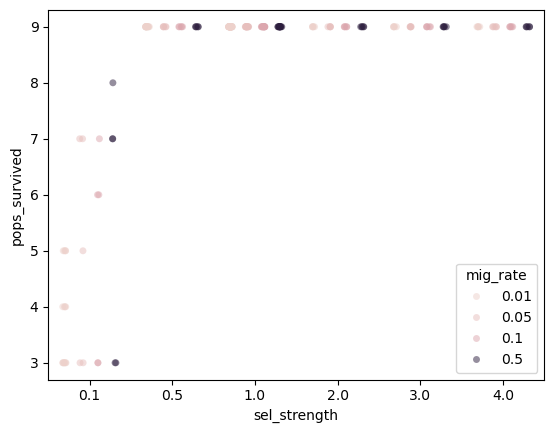

In [709]:
## first conclusion 

## if the selection strength is too strong many populations die 

# Add jitter using stripplot
sns.stripplot(data=results, x='sel_strength', y='pops_survived', hue='mig_rate', jitter=True, dodge=True, alpha=0.5, zorder=1,)

# Adjust the legend to combine both plots
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[0:len(results['mig_rate'].unique())], labels[0:len(results['mig_rate'].unique())], title="mig_rate")

# Display the plot
plt.show()


<Axes: xlabel='pops_survived', ylabel='sign_number_snps'>

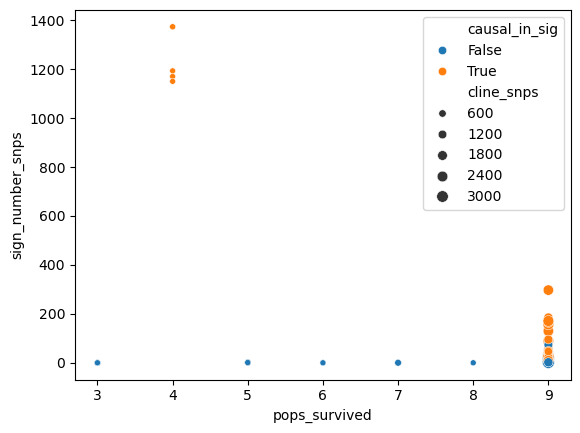

In [710]:
## ## if the selection strength is too strong many populations die 
## even tho the causal snps is still amogn the selected snps in the lfmm, the number of significan snps are too many based on lfmm 
## so the rate of false positives is very high 

## that makes sense in the sense of the power fo lfmm to identify the snps , with onlt 3 pops it is inflated 

sns.scatterplot(data=results, x = 'pops_survived' , y = 'sign_number_snps', size = 'cline_snps', hue='causal_in_sig')

<Axes: xlabel='pops_survived', ylabel='cline_snps'>

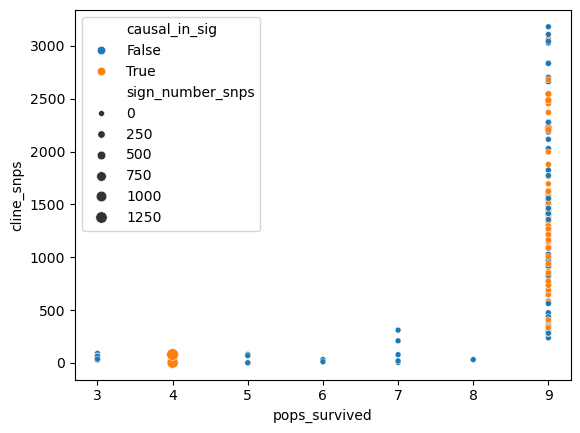

In [711]:
## also when the number of populations is really small. (3) there are not that many clines that form 
sns.scatterplot(data=results, x = 'pops_survived' , y = 'cline_snps', size = 'sign_number_snps', hue='causal_in_sig')

<Axes: xlabel='sel_strength', ylabel='sign_number_snps'>

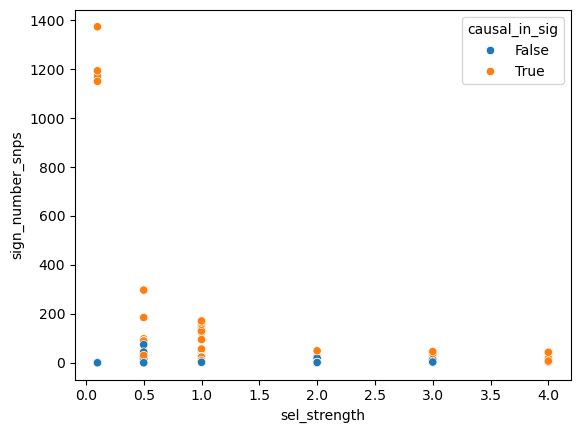

In [712]:
## also when the number of populations is really small. (3) there are not that many clines that form 
sns.scatterplot(data=results, x = 'sel_strength' , y = 'sign_number_snps', hue = 'causal_in_sig')

In [713]:
## 

ss = results[results['sel_strength'] == 0.1] # .sort_values('mig_rate')
hs = results[results['sel_strength'] == 0.5]
ls = results[results['sel_strength'] == 1]
vls = results[results['sel_strength'] == 2]
vls3 = results[results['sel_strength'] == 3]
vls4 = results[results['sel_strength'] == 4]

In [715]:
vls4['causal_in_sig'].value_counts()

causal_in_sig
True     17
False     3
Name: count, dtype: int64

In [716]:
vls4

,pops_survived,no_cline_snps,pos_cline_snps,neg_cline_snps,causal_cline,analyzed_snps,sign_number_snps,causal_present,causal_in_sig,causal_most_sign,allele1_fix,allele2_fix,sel_strength,mig_rate,final_gen,runid,cline_snps,finalno_cline_snps_gen
1,9,841,534.0,559.0,green,1134.0,20.0,True,True,False,False,False,4.0,0.10,50.0,783282,1093,841.0
19,9,1646,208.0,179.0,green,1140.0,13.0,True,True,True,True,False,4.0,0.01,50.0,391768,387,1646.0
39,9,1582,240.0,225.0,green,1133.0,8.0,True,True,True,False,False,4.0,0.01,50.0,740970,465,1582.0
68,9,2763,777.0,701.0,green,1163.0,42.0,True,True,False,True,False,4.0,0.01,200.0,149427,1478,2763.0
73,9,992,623.0,568.0,green,1267.0,29.0,True,True,False,False,False,4.0,0.10,50.0,608932,1191,992.0
77,9,978,480.0,484.0,green,1147.0,34.0,True,True,False,False,False,4.0,0.05,50.0,193383,964,978.0
84,9,970,686.0,451.0,green,1245.0,2.0,True,True,False,False,False,4.0,0.50,50.0,291057,1137,970.0
96,9,1240,1529.0,1539.0,green,1165.0,16.0,True,True,False,False,False,4.0,0.10,200.0,666168,3068,1240.0
97,9,919,867.0,896.0,green,1110.0,2.0,True,True,True,True,False,4.0,0.10,100.0,921885,1763,919.0
104,9,1017,601.0,599.0,green,1280.0,33.0,True,True,False,False,False,4.0,0.10,50.0,729914,1200,1017.0


<Axes: xlabel='mig_rate', ylabel='sign_number_snps'>

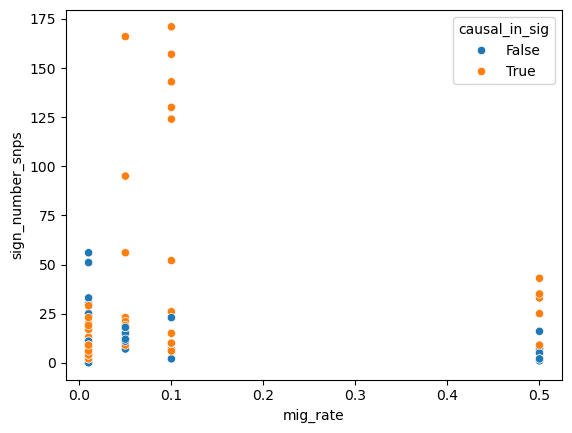

In [639]:
sns.scatterplot(data=ls, x = 'mig_rate', y = 'sign_number_snps', hue = 'causal_in_sig')

<Axes: xlabel='final_gen', ylabel='sign_number_snps'>

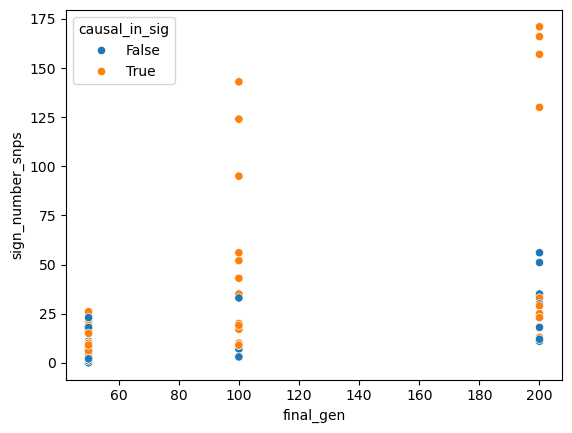

In [640]:
sns.scatterplot(data=ls, x = 'final_gen', y = 'sign_number_snps',hue = 'causal_in_sig')

<Axes: xlabel='final_gen', ylabel='mig_rate'>

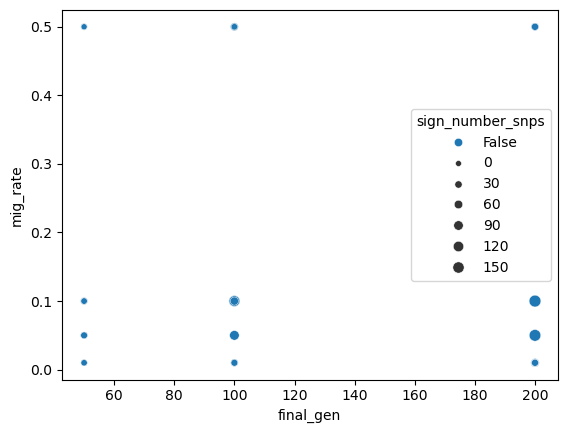

In [641]:
sns.scatterplot(data=ls, x = 'final_gen', y = 'mig_rate', size = 'sign_number_snps', hue = causal_most_sign)

<Axes: xlabel='final_gen', ylabel='mig_rate'>

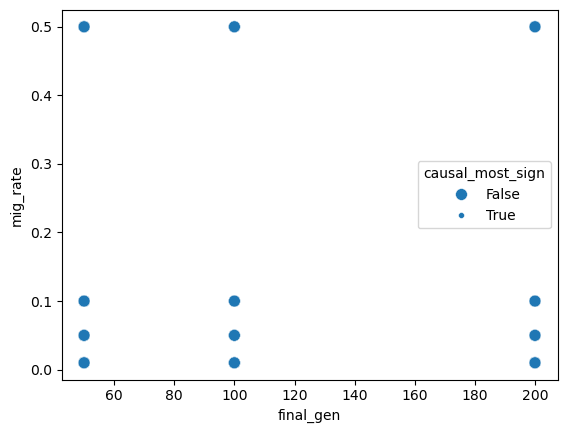

In [642]:
sns.scatterplot(data=ls, x = 'final_gen', y = 'mig_rate', size = 'causal_most_sign')

In [643]:
ls.dtypes

pops_survived              object
no_cline_snps              object
pos_cline_snps            float64
neg_cline_snps            float64
causal_cline               object
analyzed_snps             float64
sign_number_snps          float64
causal_present             object
causal_in_sig              object
causal_most_sign           object
allele1_fix                object
allele2_fix                object
sel_strength              float64
mig_rate                  float64
final_gen                 float64
runid                      object
cline_snps                 object
finalno_cline_snps_gen    float64
dtype: object

In [644]:
ls.sort_values('causal_in_sig')

,pops_survived,no_cline_snps,pos_cline_snps,neg_cline_snps,causal_cline,analyzed_snps,sign_number_snps,causal_present,causal_in_sig,causal_most_sign,allele1_fix,allele2_fix,sel_strength,mig_rate,final_gen,runid,cline_snps,finalno_cline_snps_gen
0,9,2055,277.0,391.0,green,1105.0,10.0,True,False,False,True,False,1.0,0.01,100.0,348714,668,2055.0
39,9,1036,486.0,441.0,green,1119.0,15.0,True,False,False,True,False,1.0,0.05,50.0,156362,927,1036.0
93,9,1878,130.0,107.0,green,1262.0,0.0,True,False,True,True,False,1.0,0.01,50.0,202514,237,1878.0
42,9,655,855.0,687.0,green,1254.0,2.0,True,False,False,True,False,1.0,0.50,50.0,287429,1542,655.0
118,9,1759,155.0,147.0,red,1156.0,8.0,True,False,False,False,True,1.0,0.01,50.0,930683,302,1759.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,9,1918,135.0,135.0,green,1134.0,3.0,True,True,False,True,False,1.0,0.01,50.0,195921,270,1918.0
87,9,1577,1183.0,1093.0,green,1341.0,130.0,True,True,False,True,False,1.0,0.10,200.0,863587,2276,1577.0
88,9,1060,529.0,492.0,green,1235.0,19.0,True,True,False,True,False,1.0,0.05,50.0,223257,1021,1060.0
44,9,2037,400.0,360.0,green,1205.0,20.0,True,True,False,True,False,1.0,0.01,100.0,119961,760,2037.0


In [681]:
pivot = pd.pivot_table(data = vls[vls['causal_in_sig']==True] , index = 'mig_rate', columns = 'final_gen', values = 'sign_number_snps', aggfunc='mean')
sns.heatmap(pivot, annot=True)

<Axes: xlabel='cline_snps', ylabel='final_gen'>

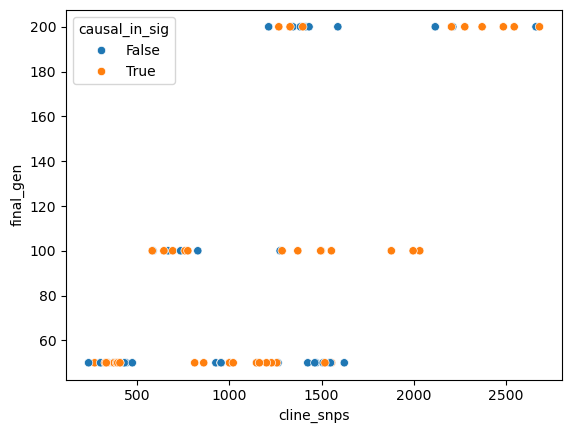

In [647]:
sns.scatterplot(data = ls,  y = 'final_gen', x = 'cline_snps', hue = 'causal_in_sig')

In [686]:
vls.sort_values('causal_in_sig')

,pops_survived,no_cline_snps,pos_cline_snps,neg_cline_snps,causal_cline,analyzed_snps,sign_number_snps,causal_present,causal_in_sig,causal_most_sign,allele1_fix,allele2_fix,sel_strength,mig_rate,final_gen,runid,cline_snps,finalno_cline_snps_gen
157,9,645,773.0,583.0,green,1097.0,2.0,True,False,False,False,False,2.0,0.50,50.0,841453,1356,645.0
22,9,667,904.0,573.0,green,1269.0,0.0,True,False,True,True,False,2.0,0.50,50.0,779732,1477,667.0
143,9,544,1300.0,978.0,green,1165.0,0.0,True,False,False,True,False,2.0,0.50,100.0,142093,2278,544.0
126,9,1804,185.0,126.0,green,1191.0,1.0,True,False,False,True,False,2.0,0.01,50.0,533885,311,1804.0
103,9,1107,1608.0,1436.0,green,1381.0,19.0,True,False,False,True,False,2.0,0.10,200.0,607983,3044,1107.0
78,9,1432,1397.0,1442.0,green,1320.0,5.0,True,False,False,True,False,2.0,0.05,200.0,906630,2839,1432.0
69,9,894,885.0,938.0,green,1124.0,5.0,True,False,False,True,False,2.0,0.10,100.0,987823,1823,894.0
159,9,671,1619.0,1490.0,green,1519.0,1.0,True,False,False,True,False,2.0,0.50,200.0,686574,3109,671.0
5,9,781,628.0,627.0,green,1111.0,7.0,True,True,False,False,False,2.0,0.10,50.0,352619,1255,781.0
86,9,534,814.0,609.0,green,1108.0,6.0,True,True,False,False,False,2.0,0.50,50.0,347434,1423,534.0


In [683]:
bests = results[(results['final_gen'] == 50) & (results['mig_rate'] == 0.01	) & (results['sel_strength'] == 2)]

In [717]:
bests = results[(results['final_gen'] == 50) & (results['sel_strength'] == 4)]

In [718]:
bests['causal_in_sig'].value_counts()

causal_in_sig
True    12
Name: count, dtype: int64

In [723]:
bests.sort_values('causal_in_sig')

,pops_survived,no_cline_snps,pos_cline_snps,neg_cline_snps,causal_cline,analyzed_snps,sign_number_snps,causal_present,causal_in_sig,causal_most_sign,allele1_fix,allele2_fix,sel_strength,mig_rate,final_gen,runid,cline_snps,finalno_cline_snps_gen
1,9,841,534.0,559.0,green,1134.0,20.0,True,True,False,False,False,4.0,0.10,50.0,783282,1093,841.0
19,9,1646,208.0,179.0,green,1140.0,13.0,True,True,True,True,False,4.0,0.01,50.0,391768,387,1646.0
39,9,1582,240.0,225.0,green,1133.0,8.0,True,True,True,False,False,4.0,0.01,50.0,740970,465,1582.0
73,9,992,623.0,568.0,green,1267.0,29.0,True,True,False,False,False,4.0,0.10,50.0,608932,1191,992.0
77,9,978,480.0,484.0,green,1147.0,34.0,True,True,False,False,False,4.0,0.05,50.0,193383,964,978.0
84,9,970,686.0,451.0,green,1245.0,2.0,True,True,False,False,False,4.0,0.50,50.0,291057,1137,970.0
104,9,1017,601.0,599.0,green,1280.0,33.0,True,True,False,False,False,4.0,0.10,50.0,729914,1200,1017.0
121,9,808,748.0,469.0,green,1149.0,2.0,True,True,True,False,False,4.0,0.50,50.0,177143,1217,808.0
128,9,1721,157.0,188.0,green,1223.0,11.0,True,True,False,False,False,4.0,0.01,50.0,602618,345,1721.0
149,9,1103,457.0,539.0,green,1229.0,18.0,True,True,False,True,False,4.0,0.05,50.0,674783,996,1103.0


In [724]:
bests['runid'].values

array(['783282', '391768', '740970', '608932', '193383', '291057',
       '729914', '177143', '602618', '674783', '177215', '738732'],
      dtype=object)

In [721]:
### how would this change with lfmm k? 
## adn teh nubmer of passed snps 
### and gwas? 
k =2

/tmp/ipykernel_798469/3916528672.py:39: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)


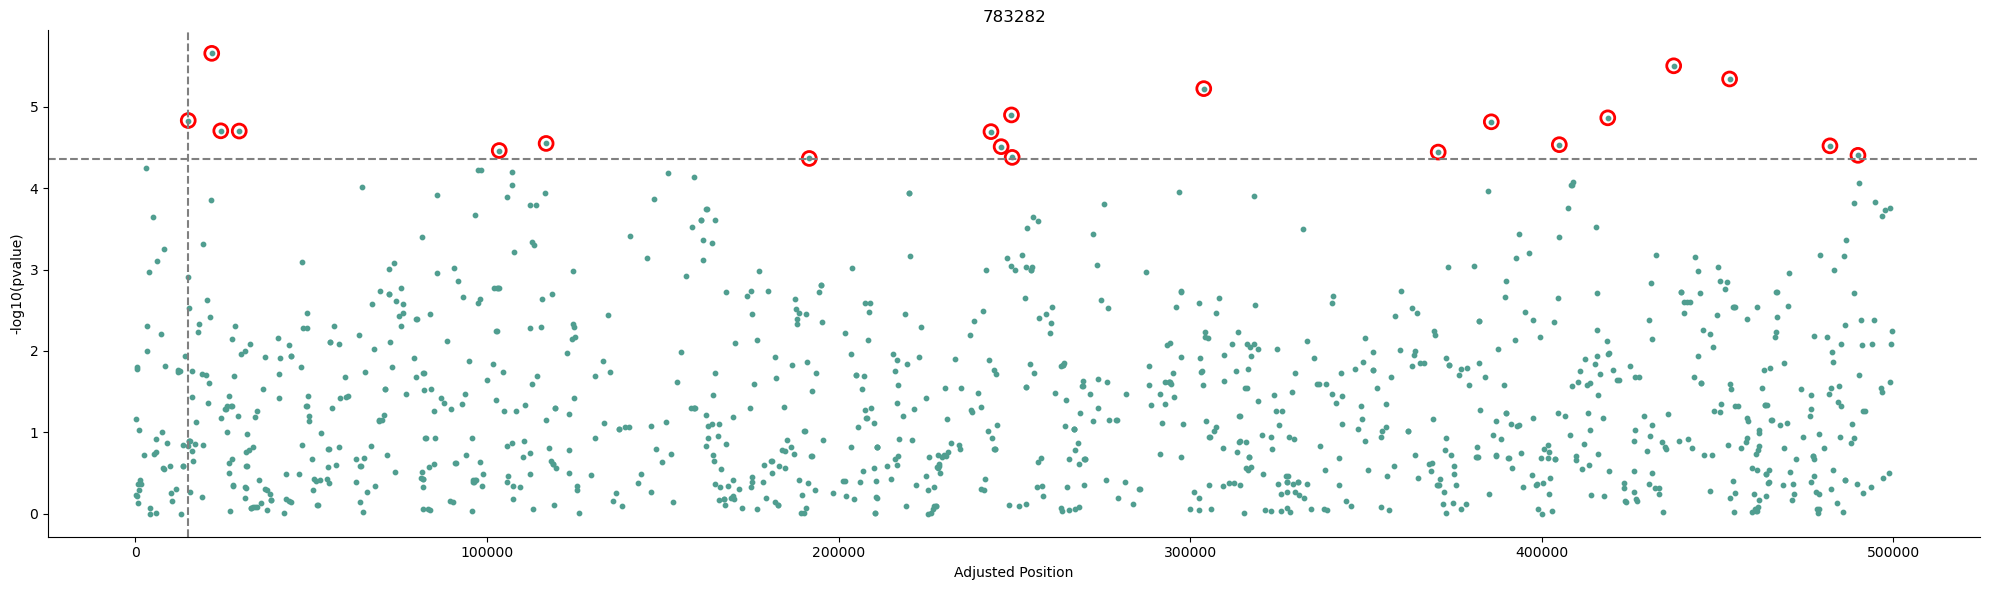

/tmp/ipykernel_798469/3916528672.py:39: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)


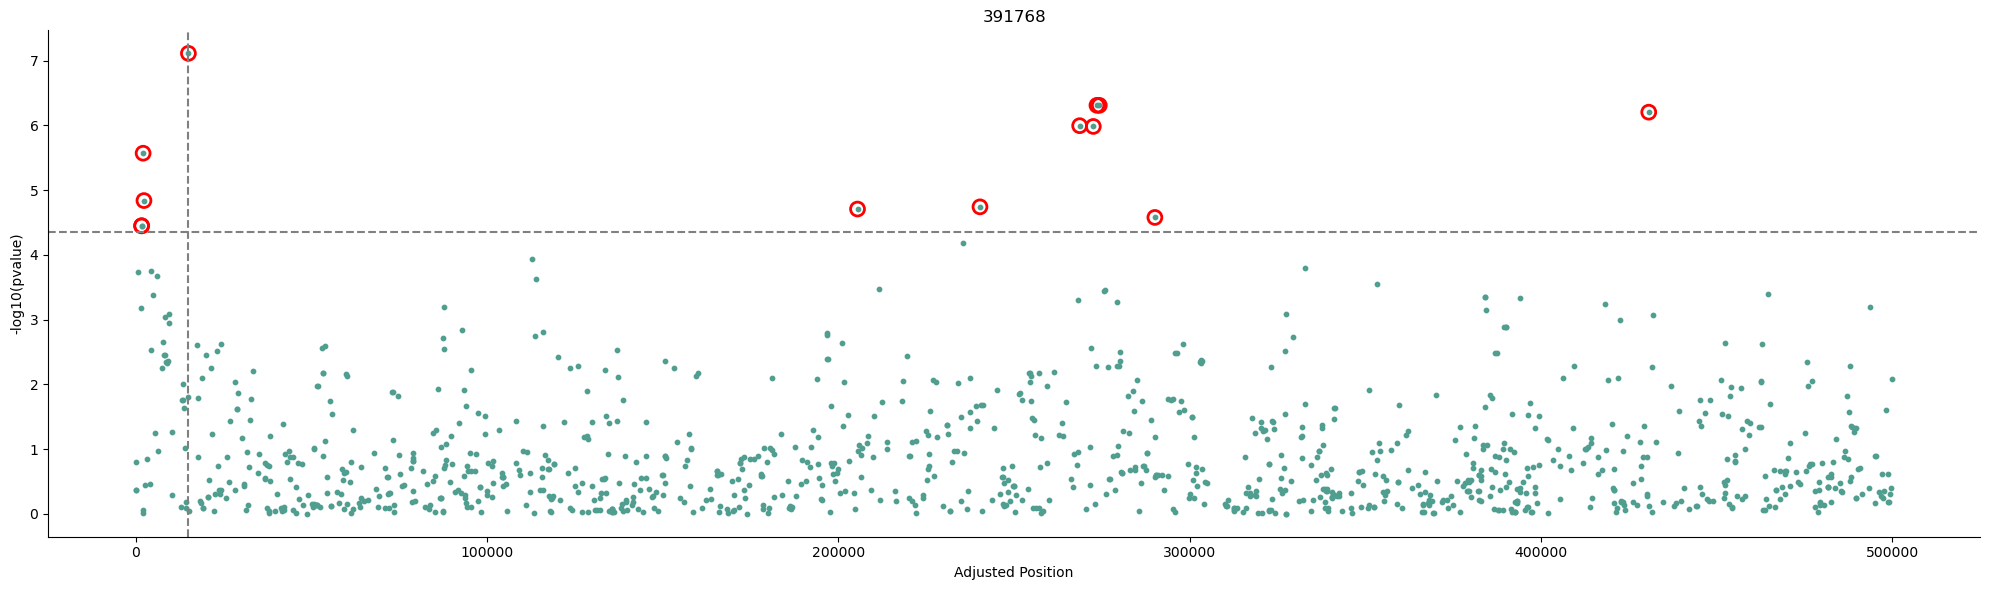

/tmp/ipykernel_798469/3916528672.py:39: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)


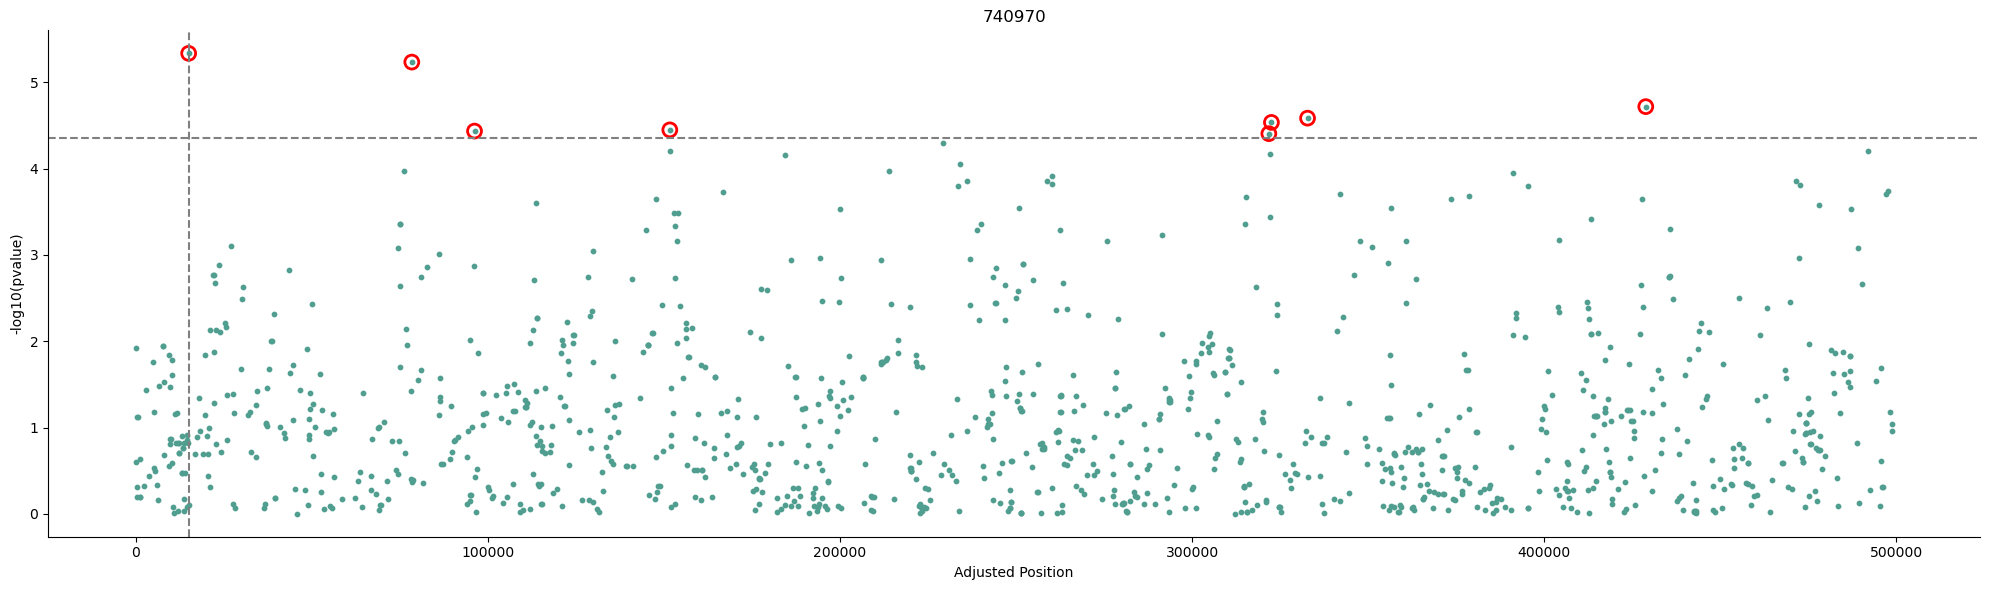

/tmp/ipykernel_798469/3916528672.py:39: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)


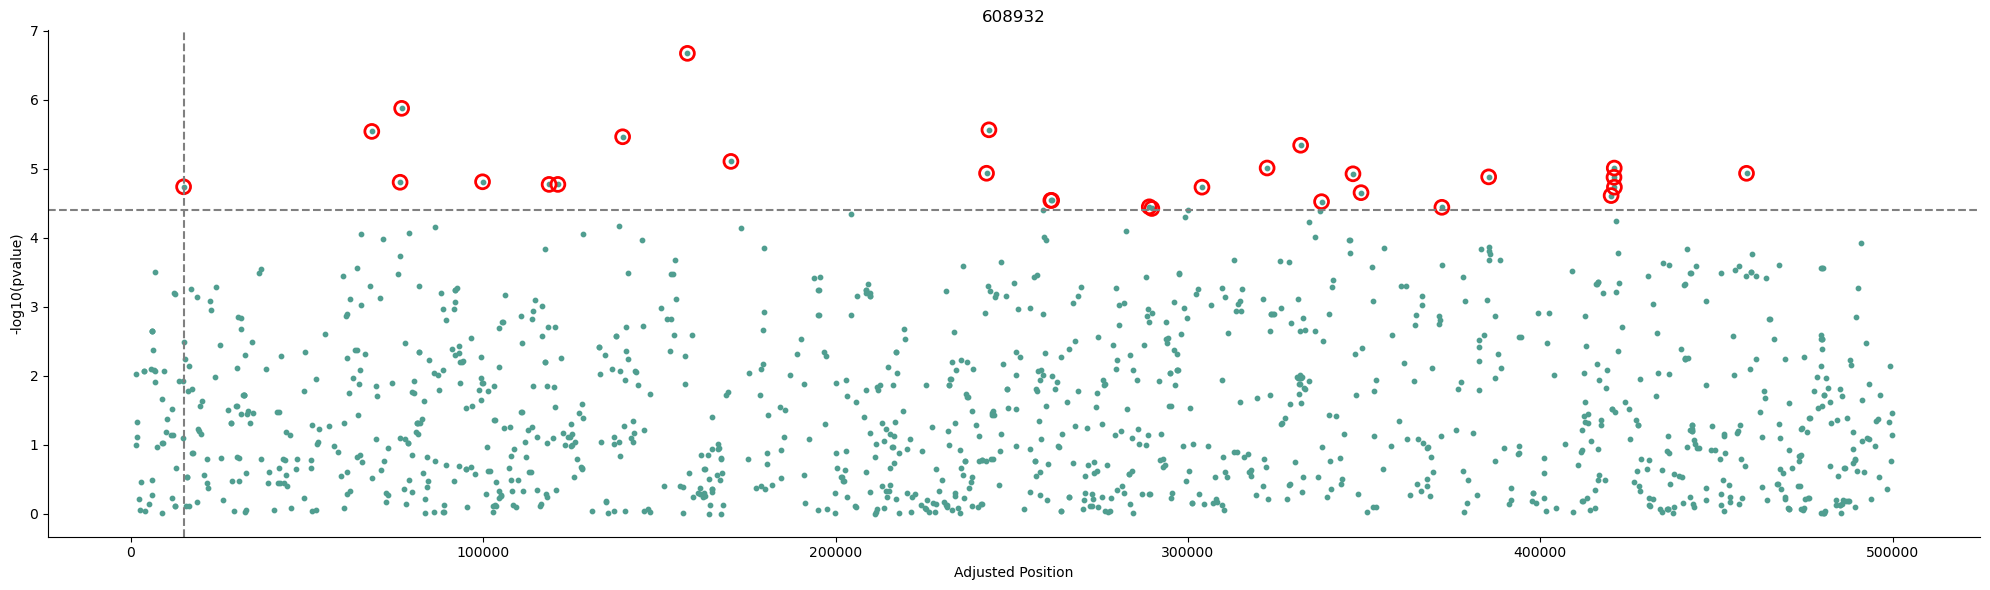

/tmp/ipykernel_798469/3916528672.py:39: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)


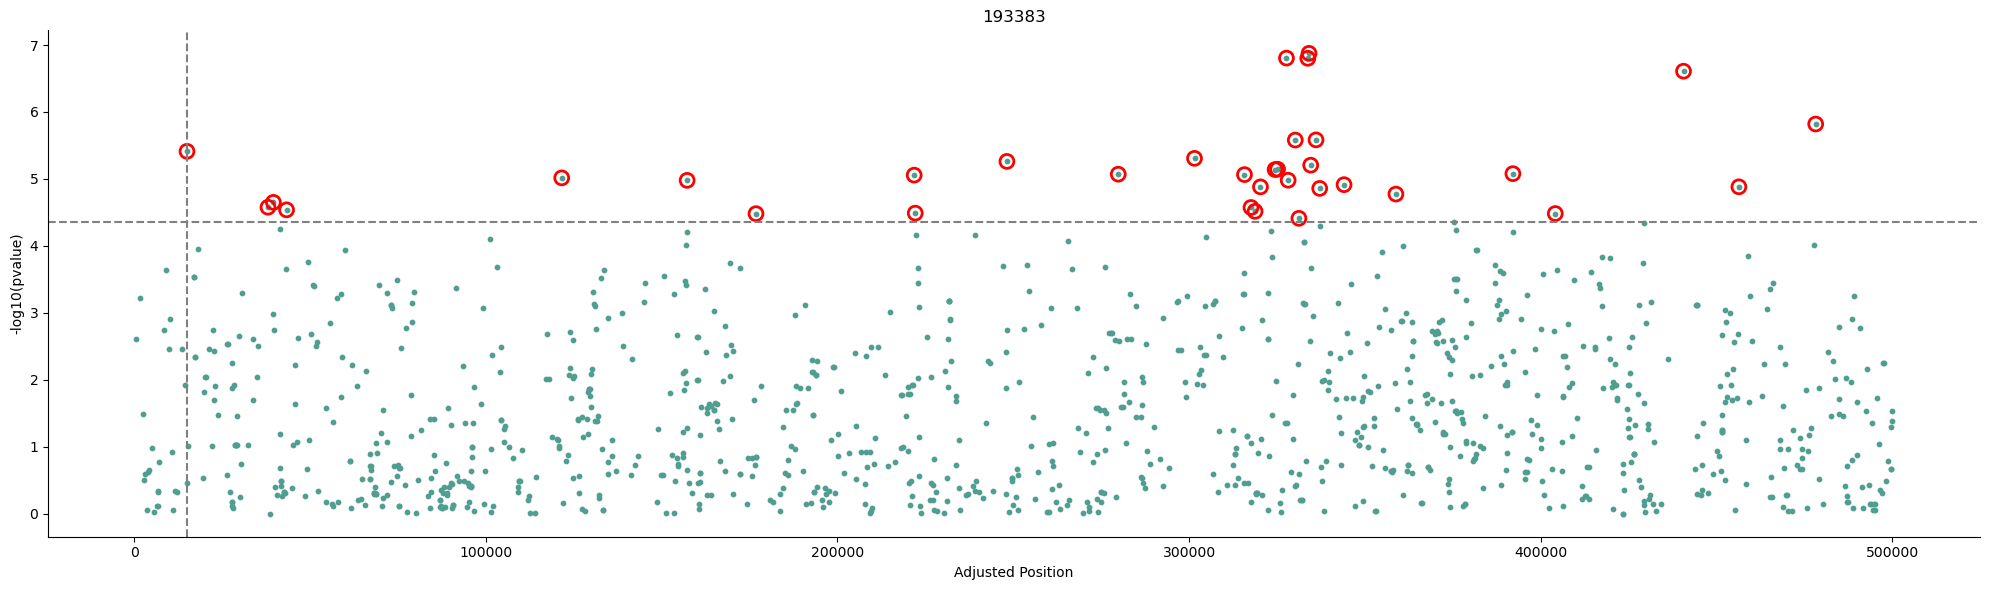

/tmp/ipykernel_798469/3916528672.py:39: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)


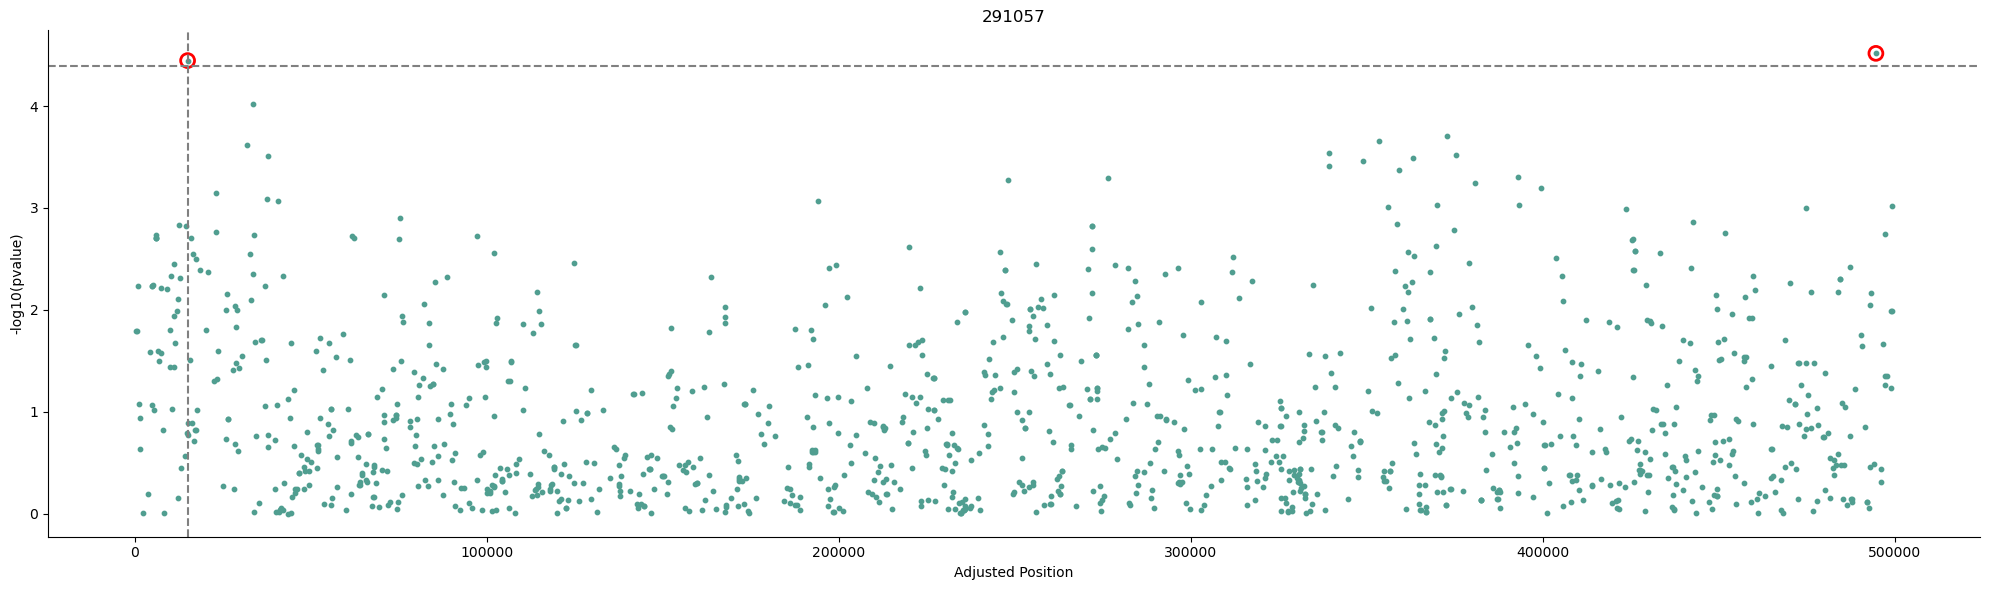

/tmp/ipykernel_798469/3916528672.py:39: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)


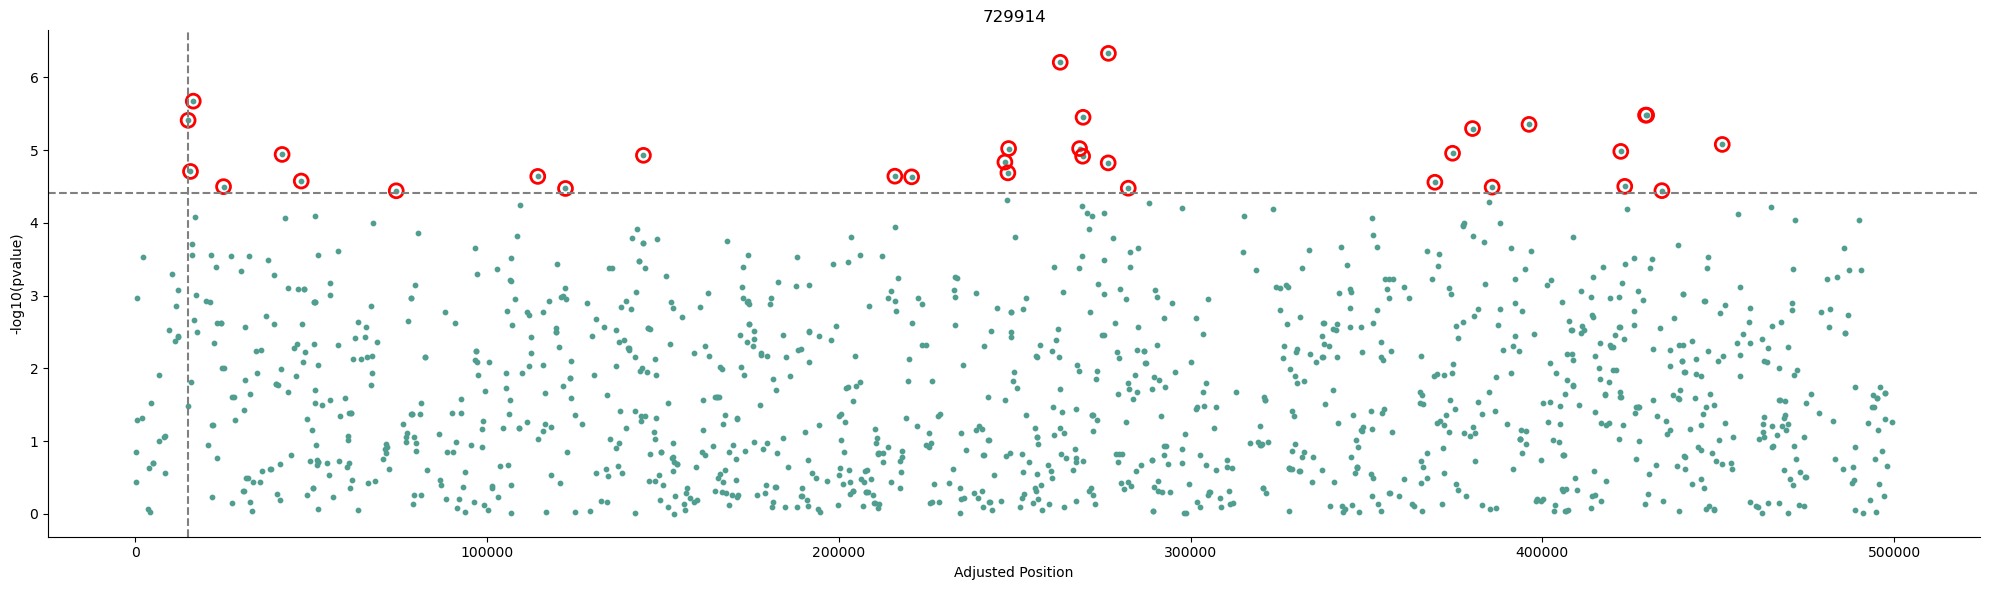

/tmp/ipykernel_798469/3916528672.py:39: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)


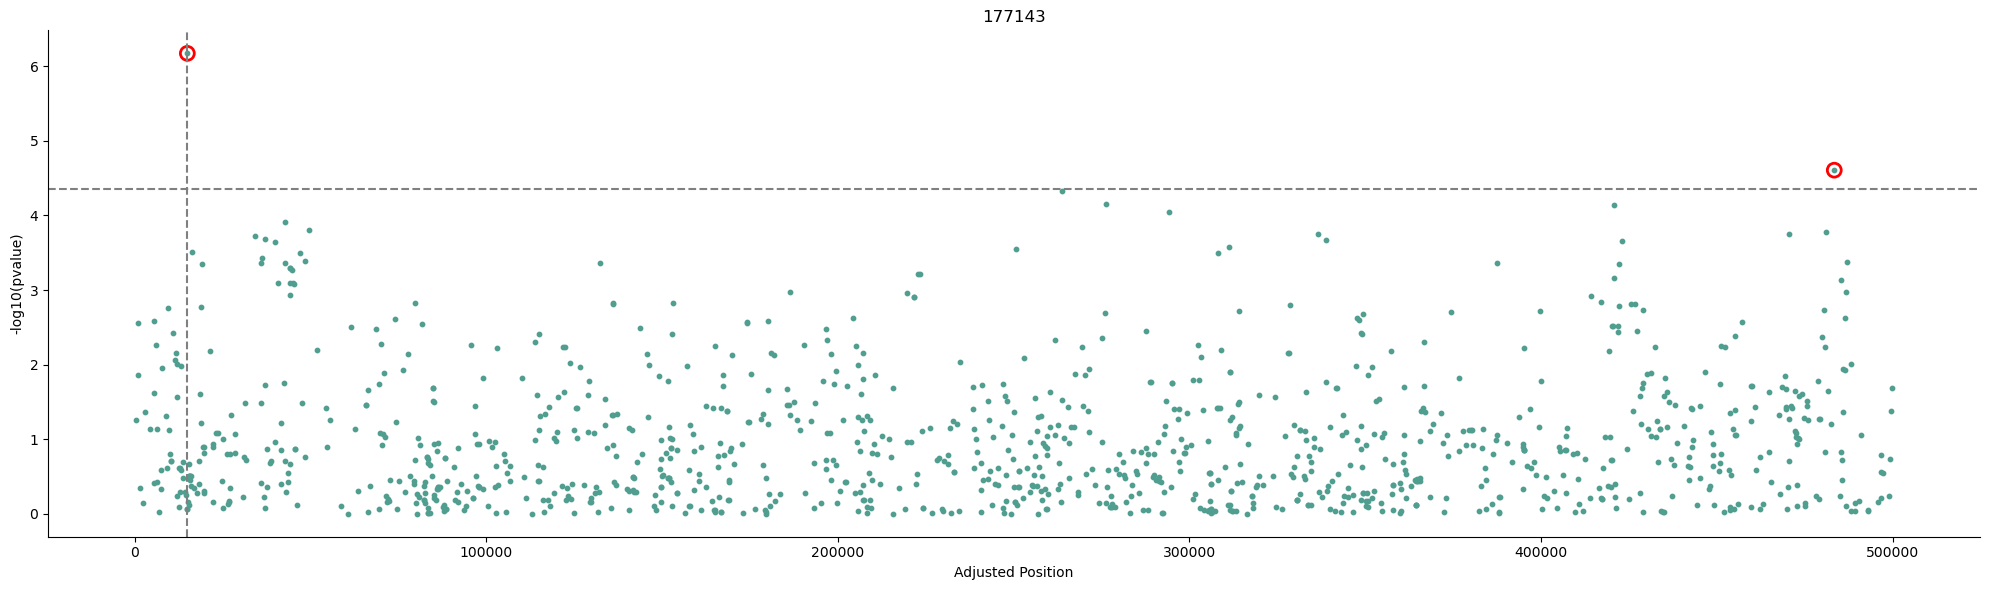

/tmp/ipykernel_798469/3916528672.py:39: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)


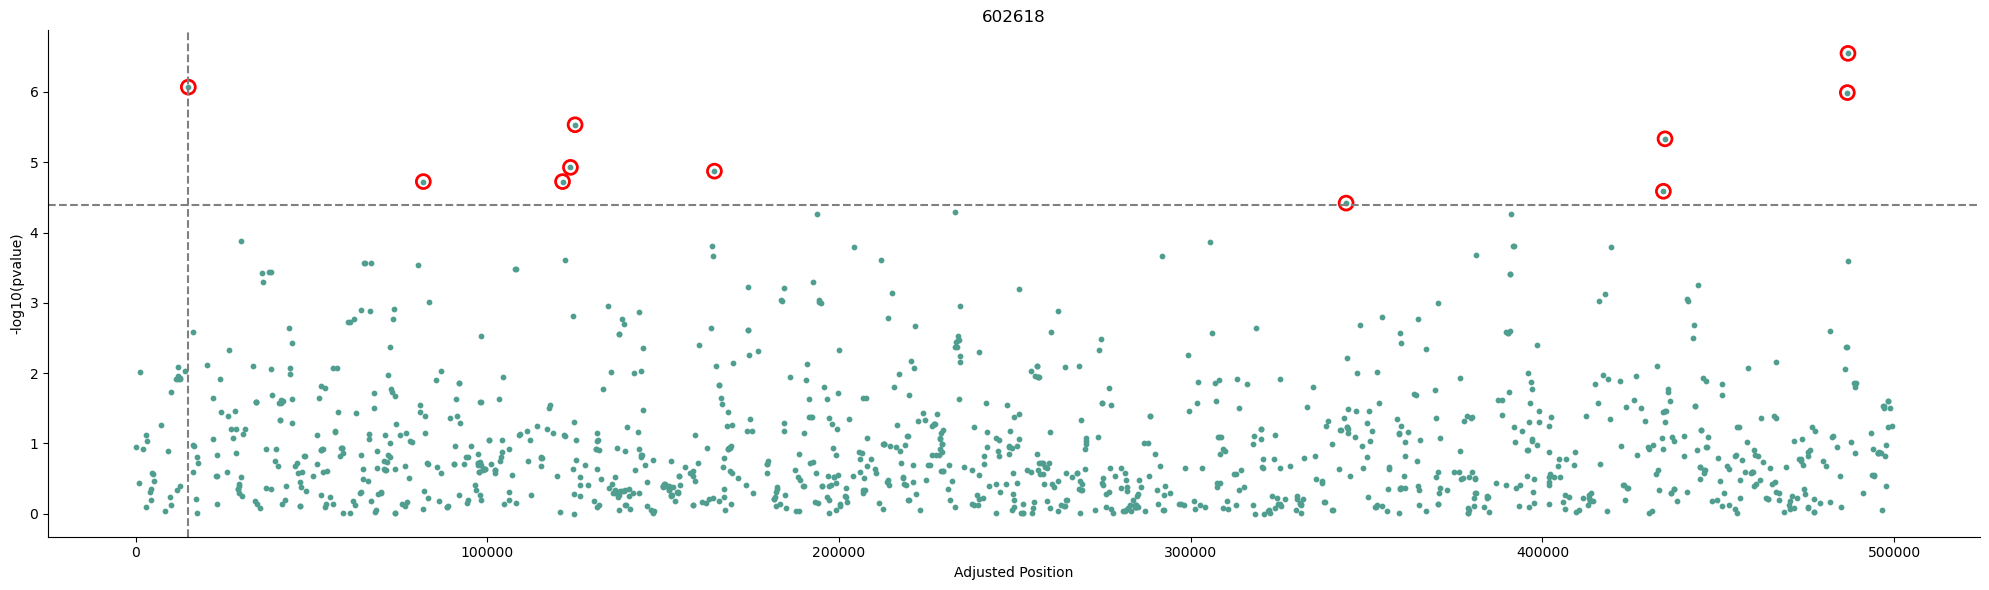

/tmp/ipykernel_798469/3916528672.py:39: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)


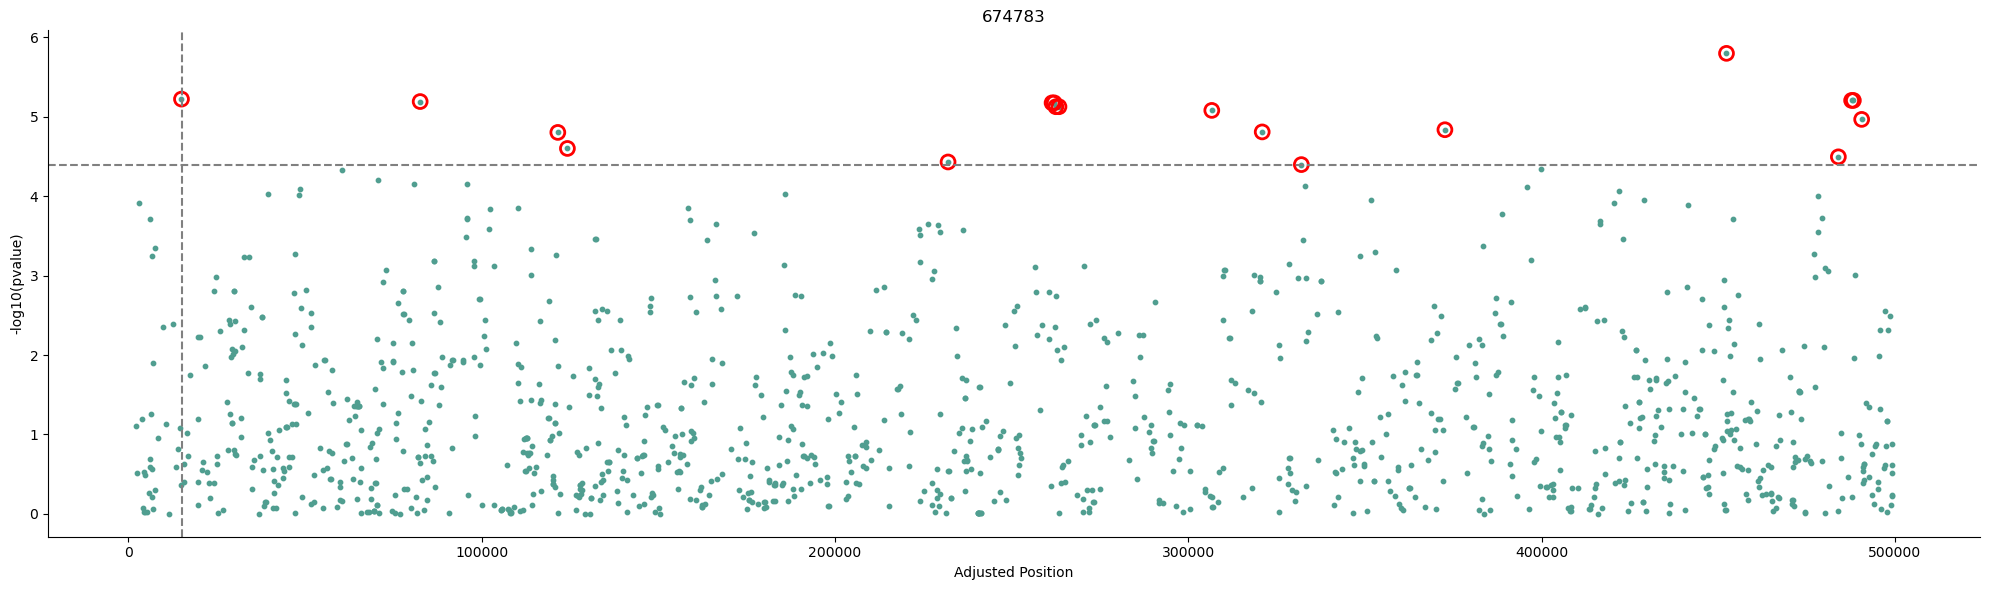

/tmp/ipykernel_798469/3916528672.py:39: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)


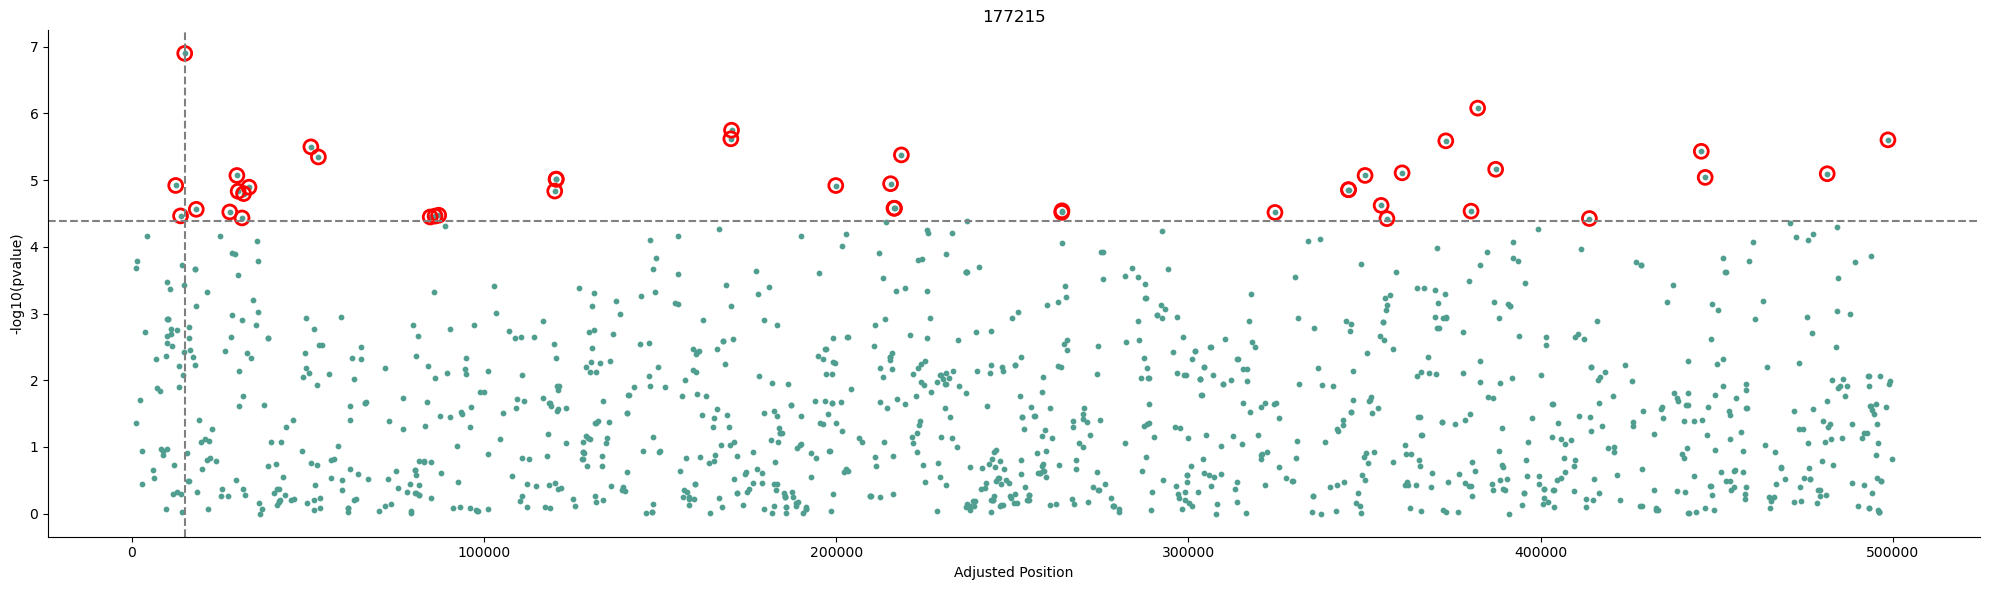

/tmp/ipykernel_798469/3916528672.py:39: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)


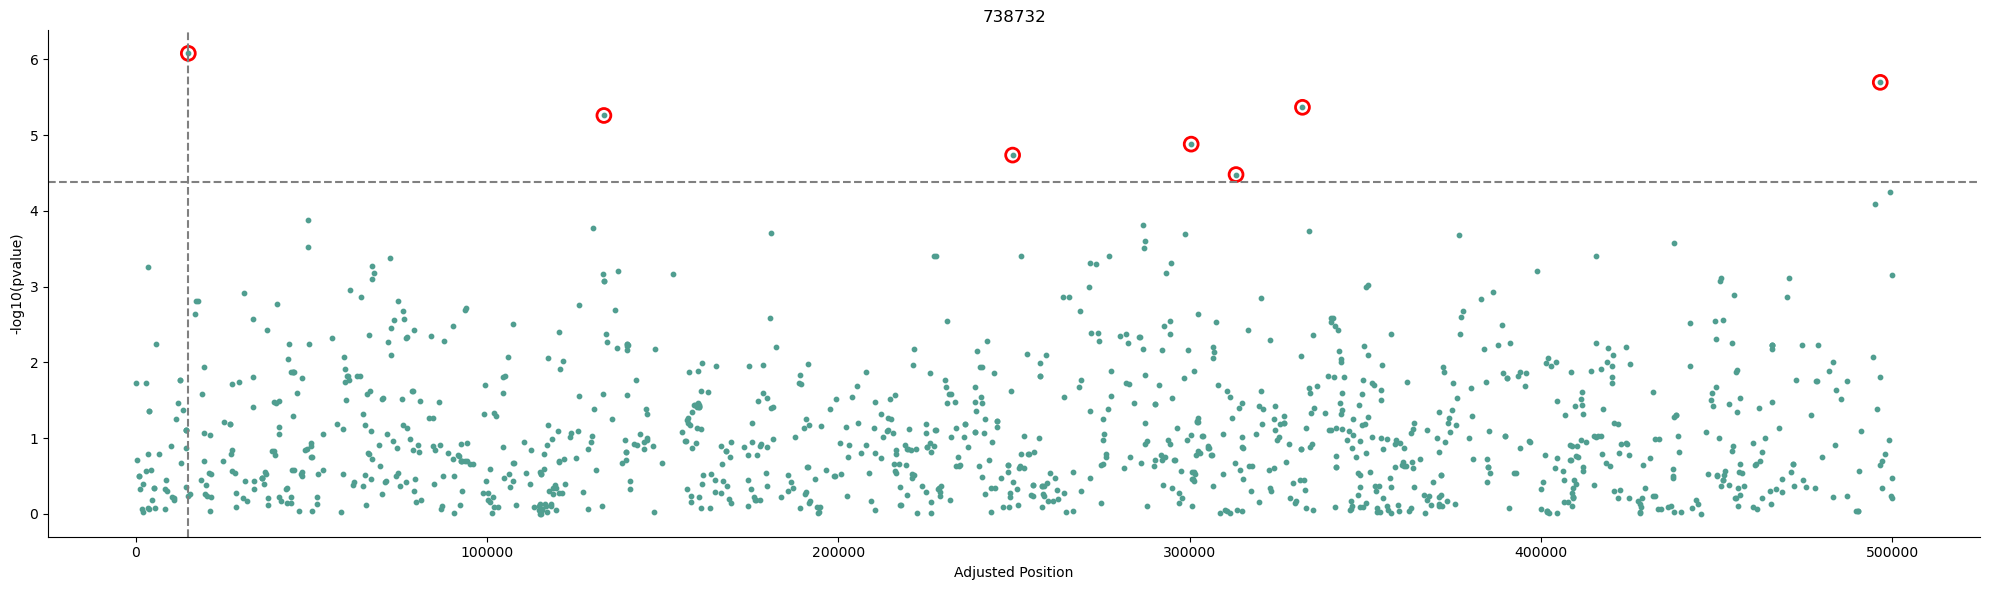

In [722]:
for runid in bests['runid'].values:
    p_values = pd.read_csv(f'lfmm/results/wo_calibration_pvalue_full_genome_{runid}_k{k}.csv').reset_index().drop( 'Unnamed: 0', axis=1)
    left_pos = pd.read_csv(f'lfmm/left_pos/left_pos_{runid}.csv')
    p_values = p_values.merge(left_pos, left_on = 'index', right_on = 'ignore', how = 'inner').drop( ['index', 'ignore'], axis=1)
    
    ts = 0.05/len(p_values)
    
    p_values.columns = ['pvalue', 'pos']
    
    threshold_value = 0.05 / len(p_values)
    
    p_values['chrom'] =1 
    
    df = p_values.copy()
    
    colors = sns.color_palette("crest", n_colors = 5)
    
    # Parsing chromosome number and position
    df['chromosome'] = df['chrom']
    df['position'] = df['pos']
    df['-log10(pvalue)'] = -np.log10(df['pvalue'])
    
    # Calculate the offset for each chromosome to prevent overlap
    chromosome_offsets = {}
    offset = 0
    for chrom in sorted(df['chromosome'].unique()):
        chromosome_offsets[chrom] = offset
        max_position = df[df['chromosome'] == chrom]['position'].max()
        offset += max_position + 1000000  # Adding 1 million as a buffer between chromosomes
    
    # Apply offsets to positions
    df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)
    
    # Creating the Manhattan plot
    plt.figure(figsize=(20, 6))
    
    for chrom in sorted(df['chromosome'].unique()):
        subset = df[df['chromosome'] == chrom]
        plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)
    
    
    # Highlight clumped SNPs
    
    # Aesthetics
    plt.xlabel('Adjusted Position')
    plt.ylabel('-log10(pvalue)')
    #plt.title('Manhattan Plot')
    #plt.grid(axis='y')
    #plt.legend(title="Chromosome", bbox_to_anchor=(1.05, 1), loc='upper left')
    ax = plt.gca()  # Get current axes
    ax.spines['top'].set_visible(False)  # Remove the top spine
    ax.spines['right'].set_visible(False)
    # Threshold line (optional)
    threshold = -np.log10(threshold_value)
    plt.axhline(y=threshold, color='grey', linestyle='dashed')
    #plt.title(f'{biovar}')  # Set the title
    
    significant_snps = df[df['-log10(pvalue)'] > threshold]
    
    # Highlight significant SNPs with red circles
    plt.scatter(significant_snps['adjusted_position'], significant_snps['-log10(pvalue)'],
                facecolors='none', edgecolors='red', s=100, linewidths=2, label='Significant SNPs')
    
    
    #intervals = [(0, 50), (5000, 5050), (10000, 10050), (15000, 15050), (20000, 20050), (25000, 25050), (30000, 30050), (35000, 35050), (40000, 40050), (45000, 45050)]
    intervals = [(15000, 15050)]
    for interval in intervals:
        middle = (interval[0] + interval[1]) / 2
        plt.axvline(x=middle, color='grey', linestyle='dashed')
    plt.title(runid)
    # Show the plot
    plt.tight_layout()
    #plt.savefig(wd + f'manhattan_{biovar}.png')
    plt.show()
    


In [350]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

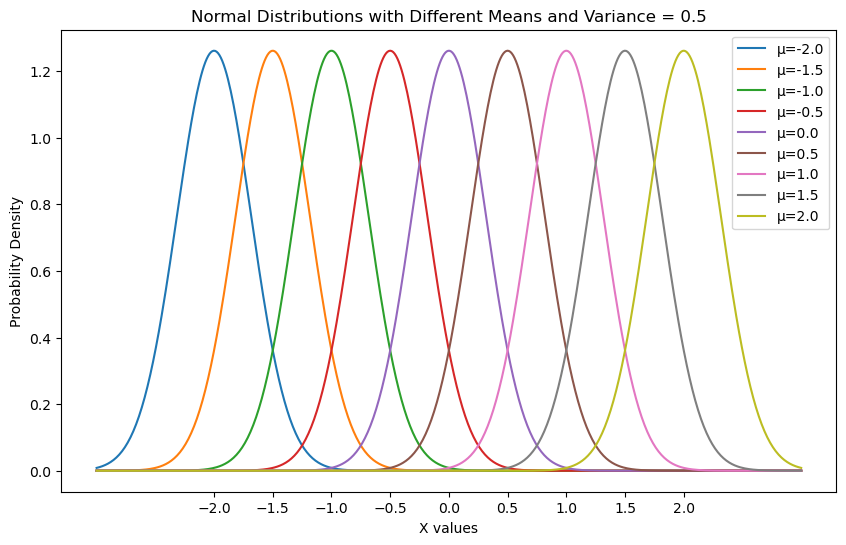

In [352]:
# X-axis values
x_values = np.array([-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2])

# Variance and standard deviation
variance = 0.1
std_dev = np.sqrt(variance)

# Create a fine grid for plotting the normal distribution
x = np.linspace(-3, 3, 500)

# Plot each normal distribution centered on the x_values
plt.figure(figsize=(10, 6))

for mu in x_values:
    # Create the normal distribution with mean=mu and std_dev
    y = norm.pdf(x, mu, std_dev)
    plt.plot(x, y, label=f'μ={mu}')

# Set x-ticks to be the specific values
plt.xticks(x_values)

# Add labels and title
plt.xlabel('X values')
plt.ylabel('Probability Density')
plt.title('Normal Distributions with Different Means and Variance = 0.5')

# Display the legend
plt.legend()

# Show the plot
plt.show()

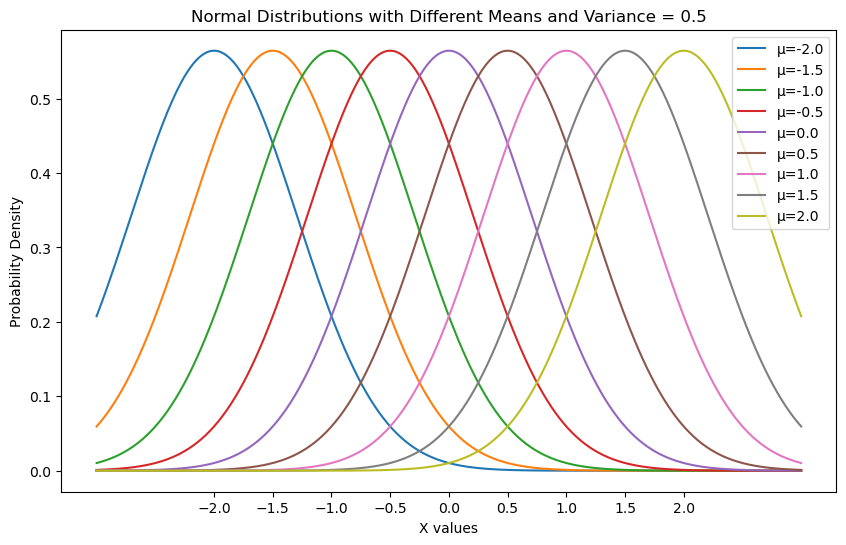

In [351]:
# X-axis values
x_values = np.array([-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2])

# Variance and standard deviation
variance = 0.5
std_dev = np.sqrt(variance)

# Create a fine grid for plotting the normal distribution
x = np.linspace(-3, 3, 500)

# Plot each normal distribution centered on the x_values
plt.figure(figsize=(10, 6))

for mu in x_values:
    # Create the normal distribution with mean=mu and std_dev
    y = norm.pdf(x, mu, std_dev)
    plt.plot(x, y, label=f'μ={mu}')

# Set x-ticks to be the specific values
plt.xticks(x_values)

# Add labels and title
plt.xlabel('X values')
plt.ylabel('Probability Density')
plt.title('Normal Distributions with Different Means and Variance = 0.5')

# Display the legend
plt.legend()

# Show the plot
plt.show()


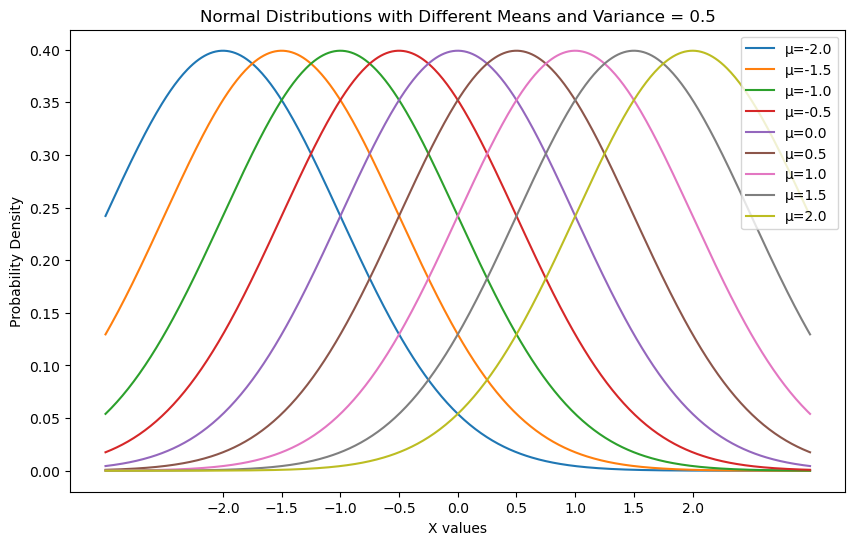

In [353]:
# X-axis values
x_values = np.array([-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2])

# Variance and standard deviation
variance = 1
std_dev = np.sqrt(variance)

# Create a fine grid for plotting the normal distribution
x = np.linspace(-3, 3, 500)

# Plot each normal distribution centered on the x_values
plt.figure(figsize=(10, 6))

for mu in x_values:
    # Create the normal distribution with mean=mu and std_dev
    y = norm.pdf(x, mu, std_dev)
    plt.plot(x, y, label=f'μ={mu}')

# Set x-ticks to be the specific values
plt.xticks(x_values)

# Add labels and title
plt.xlabel('X values')
plt.ylabel('Probability Density')
plt.title('Normal Distributions with Different Means and Variance = 0.5')

# Display the legend
plt.legend()

# Show the plot
plt.show()


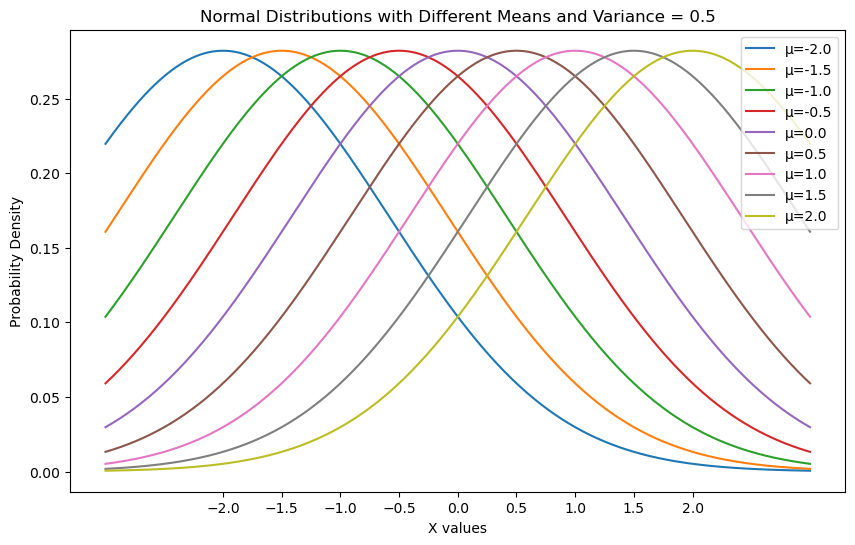

In [661]:
# X-axis values
x_values = np.array([-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2])

# Variance and standard deviation
variance = 2
std_dev = np.sqrt(variance)

# Create a fine grid for plotting the normal distribution
x = np.linspace(-3, 3, 500)

# Plot each normal distribution centered on the x_values
plt.figure(figsize=(10, 6))

for mu in x_values:
    # Create the normal distribution with mean=mu and std_dev
    y = norm.pdf(x, mu, std_dev)
    plt.plot(x, y, label=f'μ={mu}')

# Set x-ticks to be the specific values
plt.xticks(x_values)

# Add labels and title
plt.xlabel('X values')
plt.ylabel('Probability Density')
plt.title('Normal Distributions with Different Means and Variance = 0.5')

# Display the legend
plt.legend()

# Show the plot
plt.show()

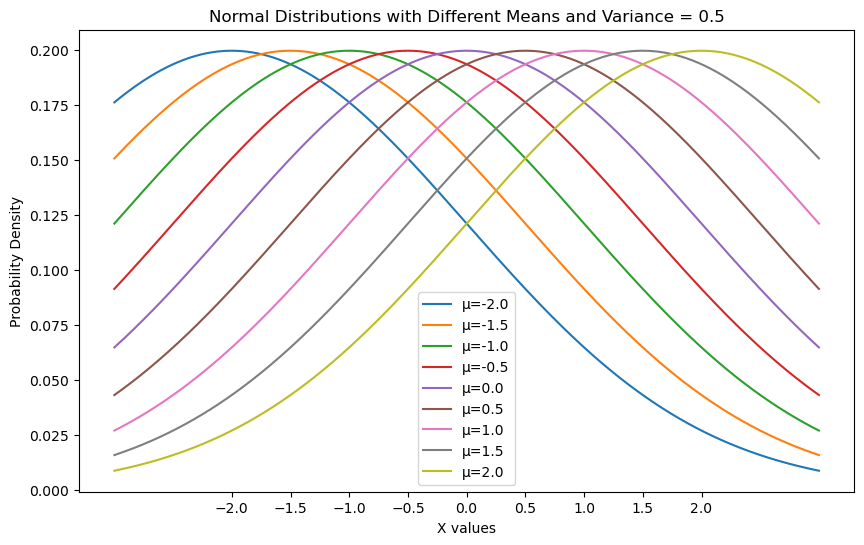

In [701]:
# X-axis values
x_values = np.array([-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2])

# Variance and standard deviation
variance = 4
std_dev = np.sqrt(variance)

# Create a fine grid for plotting the normal distribution
x = np.linspace(-3, 3, 500)

# Plot each normal distribution centered on the x_values
plt.figure(figsize=(10, 6))

for mu in x_values:
    # Create the normal distribution with mean=mu and std_dev
    y = norm.pdf(x, mu, std_dev)
    plt.plot(x, y, label=f'μ={mu}')

# Set x-ticks to be the specific values
plt.xticks(x_values)

# Add labels and title
plt.xlabel('X values')
plt.ylabel('Probability Density')
plt.title('Normal Distributions with Different Means and Variance = 0.5')

# Display the legend
plt.legend()

# Show the plot
plt.show()


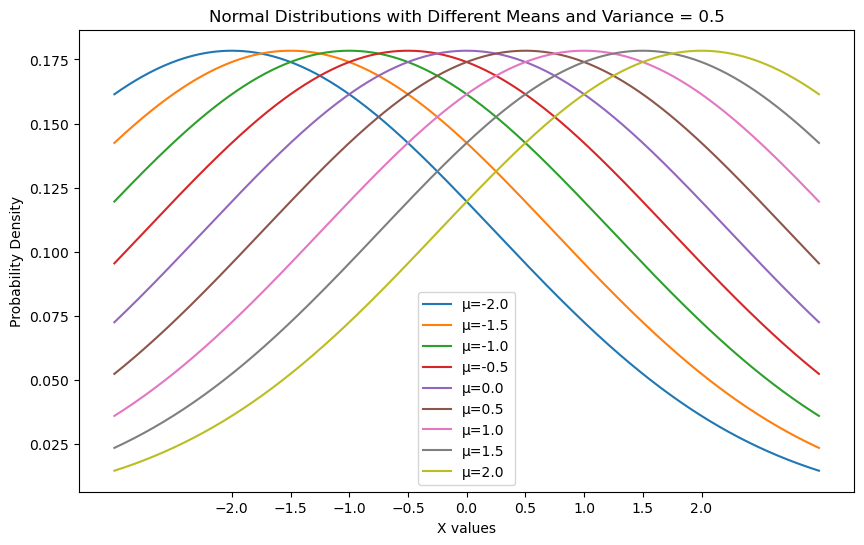

In [725]:
# X-axis values
x_values = np.array([-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2])

# Variance and standard deviation
variance = 5
std_dev = np.sqrt(variance)

# Create a fine grid for plotting the normal distribution
x = np.linspace(-3, 3, 500)

# Plot each normal distribution centered on the x_values
plt.figure(figsize=(10, 6))

for mu in x_values:
    # Create the normal distribution with mean=mu and std_dev
    y = norm.pdf(x, mu, std_dev)
    plt.plot(x, y, label=f'μ={mu}')

# Set x-ticks to be the specific values
plt.xticks(x_values)

# Add labels and title
plt.xlabel('X values')
plt.ylabel('Probability Density')
plt.title('Normal Distributions with Different Means and Variance = 0.5')

# Display the legend
plt.legend()

# Show the plot
plt.show()